In [1]:
# i want to build a more bayesian workflow to model BBHs
# so that we can keep track of uncertainty (both statistical[aleatoric] and systematic[epistemic])

# basic idea
# take an ansatz
# fit this to several examples of the same parameters
# to get multiple values (distributions) for this parameter
# marginalise over them to get 'best fit parameter'
# use the width of the distribution to estimate the uncertainty

# imports

In [2]:
# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})
default_cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
print(default_cycle_colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [3]:
from cycler import cycler
import numpy as np
from scrinet.interfaces import lalutils
import lal
import lalsimulation as lalsim
import utils 
import glob
import os


 # ignore some scipy warnings with quad
import warnings
warnings.filterwarnings('ignore')

from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [4]:
import shutil
import bilby

# load nr data

In [5]:
# get data
nrfiles_single_res = dict(
    q1="/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5",
    q2="/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5",
    q4="/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5",
    q5="/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5",
    q10="/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5",
    q18="/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5",
)

In [6]:
def make_nr_dict():
    """
    makes a dictionary of paths to NR files
    with multiple resolutions
    """
    root_dir = "/Users/spx8sk/work/data/"
    nr_ids = dict(q1="180", q2="169", q4="167", q5="107", q10="303")

    nrfiles = {}

    for key, val in nr_ids.items():
        ps = glob.glob(os.path.join(root_dir, "*" + val + "*.h5"))

        nrfiles.update({key: {}})
        for p in ps:
            k = p.split("/")[-1].split(".h5")[0].split("_")[-1]
            nrfiles[key].update({k: p})

    return nrfiles

In [7]:
nrfiles = make_nr_dict() 

In [8]:
nrfiles

{'q1': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0180_Res3.h5',
  'Res2': '/Users/spx8sk/work/data/SXS_BBH_0180_Res2.h5'},
 'q2': {'Res3': '/Users/spx8sk/work/data/SXS_BBH_0169_Res3.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
  'Res4': '/Users/spx8sk/work/data/SXS_BBH_0169_Res4.h5'},
 'q4': {'Res5': '/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0167_Res3.h5'},
 'q5': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0107_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0107_Res3.h5'},
 'q10': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0303_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0303_Res3.h5'}}

In [9]:
nrstrain_q1_res2 = utils.NRStrain(nrfiles["q1"]["Res2"], 2, 2, 1000, -3000, 100)
nrstrain_q1_res3 = utils.NRStrain(nrfiles["q1"]["Res3"], 2, 2, 1000, -3000, 100)
nrstrain_q1_res4 = utils.NRStrain(nrfiles["q1"]["Res4"], 2, 2, 1000, -3000, 100)

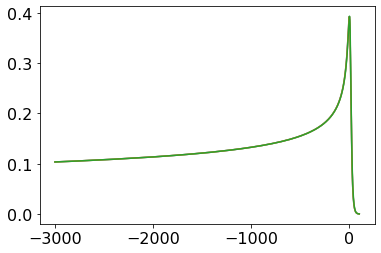

In [10]:
plt.figure()
plt.plot(nrstrain_q1_res2.times, nrstrain_q1_res2.amp)
plt.plot(nrstrain_q1_res3.times, nrstrain_q1_res3.amp)
plt.plot(nrstrain_q1_res4.times, nrstrain_q1_res4.amp)
# plt.xlim(-100,100)

In [11]:
params = lalutils.gen_td_wf_params(
    m1=20, m2=20, approximant=lalsim.SEOBNRv4PHM, f_min=12
)

In [12]:
times, amp, phase = lalutils.gen_td_wf(params, t_min=-2000, t_max=100) 

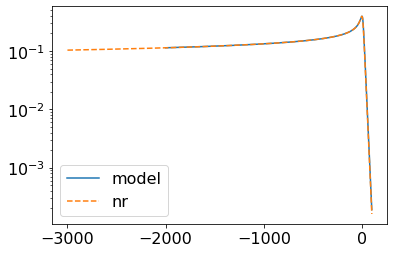

In [13]:
plt.figure()
plt.plot(
    times,
    amp
    / lalutils.td_amp_scale(40, 1)
    / lal.SpinWeightedSphericalHarmonic(0, 0, -2, 2, 2).real,
    label="model",
)
plt.plot(nrstrain_q1_res2.times, nrstrain_q1_res2.amp, ls="--", label="nr")
plt.legend()
plt.yscale("log")
# plt.xlim(-100,100)

# generate data

In [14]:
nrfiles

{'q1': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0180_Res3.h5',
  'Res2': '/Users/spx8sk/work/data/SXS_BBH_0180_Res2.h5'},
 'q2': {'Res3': '/Users/spx8sk/work/data/SXS_BBH_0169_Res3.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
  'Res4': '/Users/spx8sk/work/data/SXS_BBH_0169_Res4.h5'},
 'q4': {'Res5': '/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0167_Res3.h5'},
 'q5': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0107_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0107_Res3.h5'},
 'q10': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0303_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0303_Res3.h5'}}

In [15]:
wf_NR = {
    "Res3":utils.WaveformGeneration(nrfile=nrfiles["q10"]["Res3"]),
    "Res4":utils.WaveformGeneration(nrfile=nrfiles["q10"]["Res4"]),
    "Res5":utils.WaveformGeneration(nrfile=nrfiles["q10"]["Res5"])
}

wf_model = {
    "SEOBNRv4":utils.WaveformGeneration(approximant=lalsim.SEOBNRv4, q=10),
    "IMRPhenomB":utils.WaveformGeneration(approximant=lalsim.IMRPhenomB, q=10),
    "IMRPhenomC":utils.WaveformGeneration(approximant=lalsim.IMRPhenomC, q=10),
    "IMRPhenomD":utils.WaveformGeneration(approximant=lalsim.IMRPhenomD, q=10)
}

# old style plots and calculation

In [16]:
def plot_comparison(wgs):

    default_cycler = cycler(color=default_cycle_colors[:4]) + cycler(linestyle=["-", "--", "-.", ":"])
    plt.rc("axes", prop_cycle=default_cycler)

    titles = ["amp", "phase", "freq"]

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    for wg in wgs:
        label = wg.label
        axes[0].plot(wg.times, wg.amp, label=label)
        axes[1].plot(wg.times, wg.phase, label=label)
        axes[2].plot(wg.times, wg.freq, label=label)
    axes[0].legend()
    for i, ax in enumerate(axes):
        ax.set_title(titles[i])

    fig.text(0.5, 0.04, "time/M", ha="center")

    plt.show()
    plt.close()

In [17]:
def plot_raw_difference(wgs):

    default_cycler = cycler(color=default_cycle_colors[:4]) + cycler(linestyle=["-", "--", "-.", ":"])
    plt.rc("axes", prop_cycle=default_cycler)

    titles = ["amp", "phase", "freq"]
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    for wg in wgs[1:]:
        label = f"{wgs[0].label} - {wg.label}"
        axes[0].plot(wg.times, wgs[0].amp - wg.amp, label=label)
        axes[1].plot(wg.times, wgs[0].phase - wg.phase, label=label)
        axes[2].plot(wg.times, wgs[0].freq - wg.freq, label=label)
    axes[0].legend()
    for i, ax in enumerate(axes):
        ax.set_title(titles[i])

    fig.text(0.5, 0.04, "time/M", ha="center")

    plt.show()
    plt.close()

In [18]:

def dephasing(z, i1, i2, win1, win2):
    dt, dphi = z
    return quad(lambda t: np.abs((i1(t)-i2(t+dt)+dphi)),win1,win2)[0]

def compute_phase_diff(times1, phase1, times2, phase2, win1, win2, x0=[0.,0.], return_x=False):
    i1 = IUS(times1, phase1)
    i2 = IUS(times2, phase2)
    args = (i1, i2, win1, win2)
    mini = minimize(dephasing, x0, args=args, tol=1e-12).x
    dt = mini[0]
    dphi = mini[1]
    
    i2new = IUS(times2 + dt, phase2 - dphi)
    newphase = i2new(times1)
    print("not sure if subtracting off the zero phase is correct. check this!")
    newphase -= newphase[0]
    if return_x:
        return newphase, [dt, dphi]
    else:
        return newphase
    
def plot_aligned_difference(wgs, win1=-2000, win2=-1000):

    default_cycler = cycler(color=default_cycle_colors[:4]) + cycler(linestyle=["-", "--", "-.", ":"])
    plt.rc("axes", prop_cycle=default_cycler)

    titles = ["amp", "phase", "freq"]
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    for wg in wgs[1:]:
        label = f"{wgs[0].label} - {wg.label}"
        
        newphase, [dt, _] = compute_phase_diff(wgs[0].times, wgs[0].phase, wg.times, wg.phase, win1=win1, win2=win2, return_x=True)
        newamp = IUS(wg.times + dt, wg.amp)(wgs[0].times)
        newfreq = IUS(wg.times + dt, wg.freq)(wgs[0].times)
        
        axes[0].plot(wgs[0].times, wgs[0].amp - newamp, label=label)
        axes[1].plot(wgs[0].times, wgs[0].phase - newphase, label=label)
        axes[2].plot(wgs[0].times, wgs[0].freq - newfreq, label=label)
    axes[0].legend()
    for i, ax in enumerate(axes):
        ax.set_title(titles[i])

    fig.text(0.5, 0.04, "time/M", ha="center")

    
    axes[2].set_ylim(-0.1,0.1)
        
    plt.show()
    plt.close()

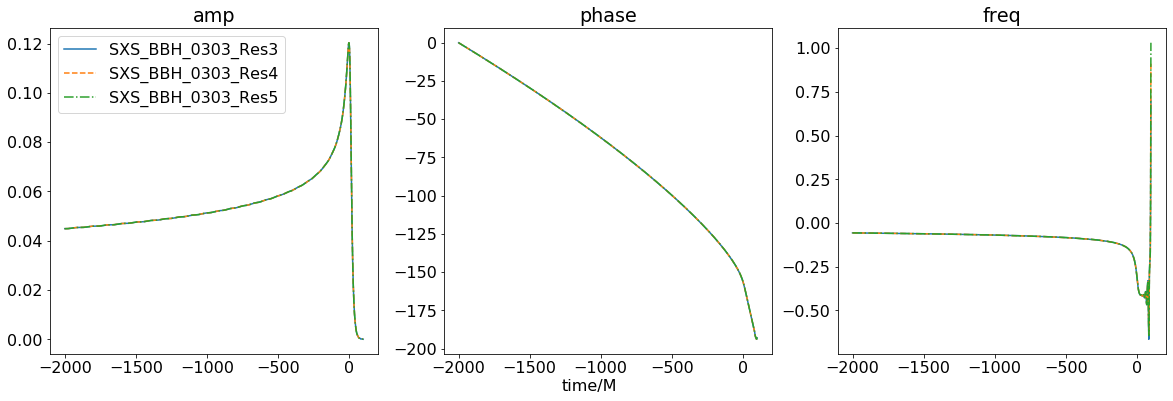

In [19]:
plot_comparison([wf_NR["Res3"], wf_NR["Res4"], wf_NR["Res5"]]) 

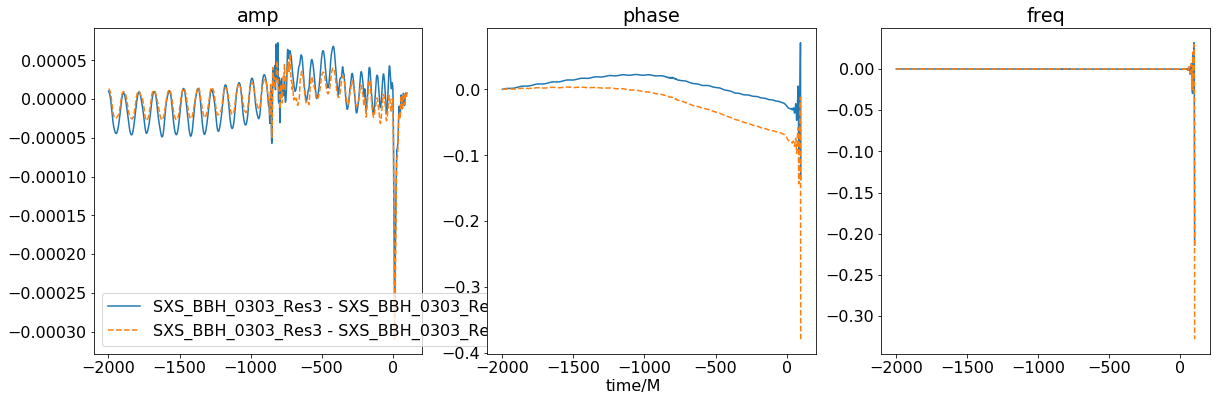

In [20]:
plot_raw_difference([wf_NR["Res3"], wf_NR["Res4"], wf_NR["Res5"]]) 

In [21]:
# plot_aligned_difference([wf_NR["Res3"], wf_NR["Res4"], wf_NR["Res5"]]) 

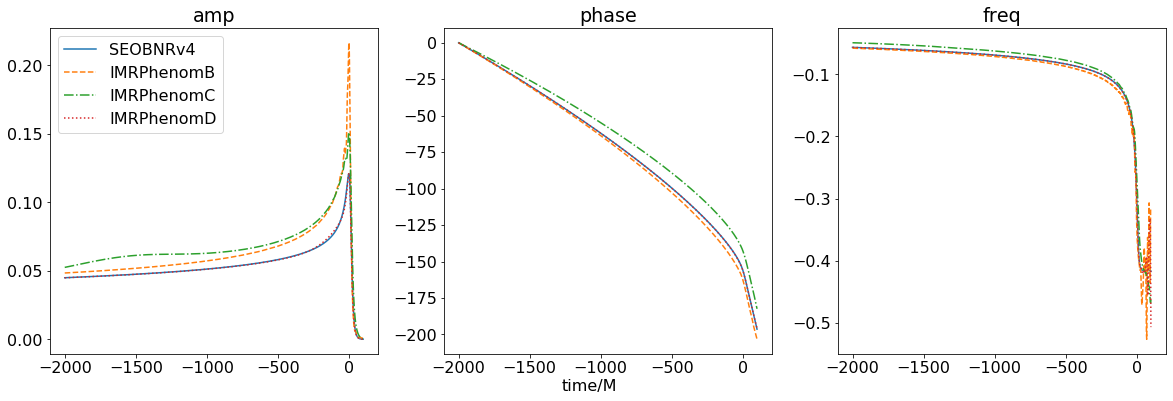

In [22]:
plot_comparison([wf_model["SEOBNRv4"], wf_model["IMRPhenomB"], wf_model["IMRPhenomC"], wf_model["IMRPhenomD"]]) 

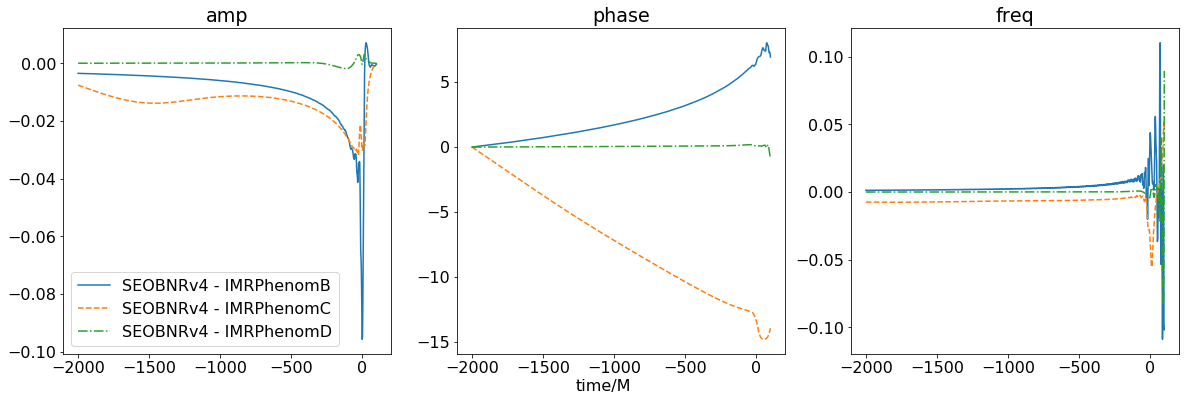

In [23]:
plot_raw_difference([wf_model["SEOBNRv4"], wf_model["IMRPhenomB"], wf_model["IMRPhenomC"], wf_model["IMRPhenomD"]]) 

In [24]:
# plot_aligned_difference([wf_model["SEOBNRv4"], wf_model["IMRPhenomB"], wf_model["IMRPhenomC"], wf_model["IMRPhenomD"]]) 

# newer stuff

In [25]:
# take ansatz from phenomTHM: https://arxiv.org/abs/2012.11923
# also check out my presentation: https://gitlab.com/SpaceTimeKhantinuum/presentations/-/blob/master/nov2020-cardiff-data-analysis/waveforms.ipynb

(-300, 10)

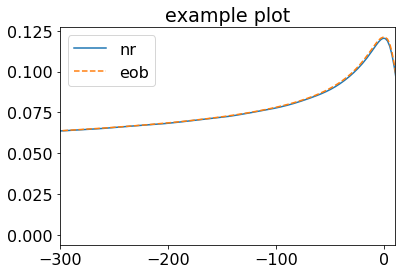

In [26]:
plt.figure()
plt.plot(wf_NR["Res3"].times, wf_NR["Res3"].amp, label='nr')
plt.plot(wf_model["SEOBNRv4"].times, wf_model["SEOBNRv4"].amp, label='eob')
plt.legend()
plt.title('example plot');
plt.xlim(-300, 10)

In [175]:
def sech(x, a):
    return 1./np.cosh(a*x)

def amp_merger_model(x, b0, b1, b2, a1):
    """equation 16 from 2004.08302
    
    also modified
    """
    return \
        b0 + \
        b1 * x + \
        b2 * sech(x, a1)**(1/7.)
# + \
#         b3 * sech(x, a1)

In [176]:
def mask_data_to_fit(x, y, x1, x2):
    mask = (x >= x1) & (x <= x2)
    
    return x[mask], y[mask]

In [177]:
x, y = mask_data_to_fit(wf_NR["Res3"].times, wf_NR["Res3"].amp, -200, 0)

In [178]:
# amp_merger_model(x=x, b0=1, b1=1, b2=1, b3=1, a1=1, a2=1)

In [179]:
x.shape

(95,)

In [180]:
# plt.figure()
# plt.plot(x, y)
# plt.plot(x, amp_merger_model(x=x, b0=1, b1=1, b2=1, b3=1, a1=1))

best fit params: [8.25509815e-02 7.26979726e-05 3.81293939e-02 1.99929533e-01]


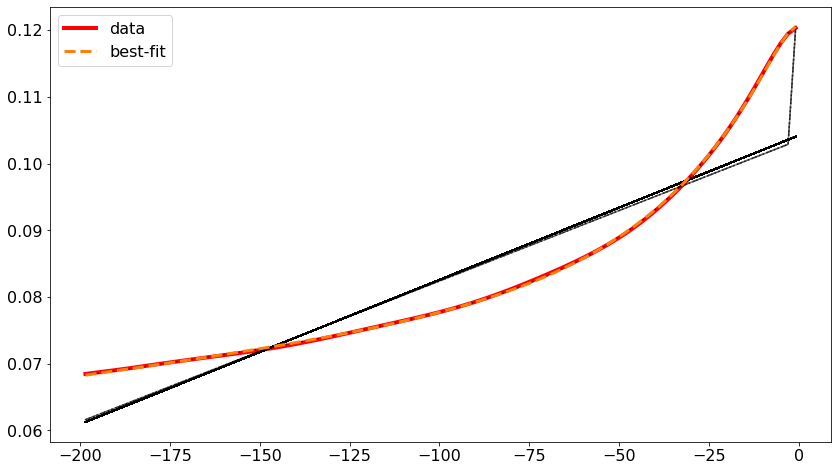

In [181]:
# fit using scipy non-linear least-squares fitting method e.g. Levenberg-Marquardt
from scipy.optimize import curve_fit

# mean squared error
def mse(y, yhat):
    return np.mean((y-yhat)**2)

ntries = 500
popts = []
mses = np.zeros(ntries)

plt.figure(figsize=(14, 8))
plt.plot(x, y, label='data', lw=4, c='r')

for i in range(ntries):

    p0 = np.random.uniform(-1000, 1000, size=(4))
    popt, pcov = curve_fit(amp_merger_model, x, y, p0=p0, method='lm')
    
    popts.append(popt)
    mses[i] = mse(y, amp_merger_model(x, *popt))
    plt.plot(x, amp_merger_model(x, *popt), color='k', alpha=0.3)

ii = np.argmin(mses)

best_popt = np.array(popts[ii])
yhat = amp_merger_model(x, *best_popt)

print(f"best fit params: {best_popt}")

    
plt.plot(x, yhat, ls='--', label='best-fit', color='C9', lw=3)
plt.legend()


In [182]:
def run_bilby(x, y, model_fn, label='amp_test', delete_outdir=False, sampler='dynesty'):
    """
    x, y : the independent and the dependent data. np.array each of shape (N,)
            where N is the number of data points
    model_fn: callable python function. the model/ansatz
    """
    # A few simple setup steps
    outdir = label
    bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)
    
    if delete_outdir:
        shutil.rmtree(outdir)
    
    likelihood = bilby.likelihood.GaussianLikelihood(x, y, model_fn, sigma=None)
    
    priors = dict()
    
    priors['b0'] = bilby.core.prior.Uniform(-10, 10, 'b0')
    priors['b1'] = bilby.core.prior.Uniform(-10, 10, 'b1')
    priors['b2'] = bilby.core.prior.Uniform(-10, 10, 'b2')
    priors['a1'] = bilby.core.prior.Uniform(-10, 10, 'a1')
    
    
#     priors['b1'] = bilby.core.prior.Uniform(-3.54472896e-07 - 1, -3.54472896e-07 + 1, 'b1')
#     priors['b2'] = bilby.core.prior.Uniform(4.20644543e-02 - 10 , 4.20644543e-02 + 10 , 'b2')
#     priors['b3'] = bilby.core.prior.Uniform(5.87704719e+02 - 1000, 5.87704719e+02 + 1000, 'b3')
#     priors['a1'] = bilby.core.prior.Uniform(-1.97315666e-01 - 10 , -1.97315666e-01 + 10 , 'a1')
#     priors['a2'] = bilby.core.prior.Uniform(-4.45441979e+02 - 100, -4.45441979e+02 + 100, 'a2')
    
#     priors['b0'] = bilby.core.prior.DeltaFunction(7.85331547e-02, 'b0')
#     priors['b1'] = bilby.core.prior.DeltaFunction(-3.54472896e-07, 'b1')
#     priors['b2'] = bilby.core.prior.DeltaFunction(4.20644543e-02, 'b2')
#     priors['b3'] = bilby.core.prior.DeltaFunction(5.87704719e+02, 'b3')
#     priors['a1'] = bilby.core.prior.DeltaFunction(-1.97315666e-01, 'a1')
#     priors['a2'] = bilby.core.prior.DeltaFunction(-4.45441979e+02, 'a2')


    
    priors['sigma'] = bilby.core.prior.LogUniform(1e-6, 1, 'sigma')
    
    result = bilby.run_sampler(
        likelihood=likelihood, priors=priors, sampler=sampler,
        nsteps=200,
        ntemps=4,
        nlive=500,
        sample='unif',
        outdir=outdir,
        label=label)
    
    
    result.plot_corner()

    return result

In [183]:
result = run_bilby(x, y, amp_merger_model, label='amp_test', delete_outdir=True, sampler='emcee')

21:22 bilby INFO    : Running for label 'amp_test', output will be saved to 'amp_test'
21:22 bilby INFO    : Search parameters:
21:22 bilby INFO    :   b0 = Uniform(minimum=-10, maximum=10, name='b0', latex_label='b0', unit=None, boundary=None)
21:22 bilby INFO    :   b1 = Uniform(minimum=-10, maximum=10, name='b1', latex_label='b1', unit=None, boundary=None)
21:22 bilby INFO    :   b2 = Uniform(minimum=-10, maximum=10, name='b2', latex_label='b2', unit=None, boundary=None)
21:22 bilby INFO    :   a1 = Uniform(minimum=-10, maximum=10, name='a1', latex_label='a1', unit=None, boundary=None)
21:22 bilby INFO    :   sigma = LogUniform(minimum=1e-06, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
21:22 bilby INFO    : Single likelihood evaluation took 2.109e-04 s
21:22 bilby WARNING : Supplied argument 'npool' not an argument of 'Emcee', removing.
21:22 bilby WARNING : Supplied argument 'ntemps' not an argument of 'Emcee', removing.
21:22 bilby WARNING : Supplied ar

In [36]:
# result = run_bilby(x, y, amp_merger_model, label='amp_test', delete_outdir=True, sampler='dynesty')

In [37]:
# result = run_bilby(x, y, amp_merger_model, label='amp_test', delete_outdir=True, sampler='ptemcee')